# **최적화** (완료) 

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [42]:
def get_order_parameter(theta,N):
    ''' get theta and return r and theta'''
    rpsi = 1/N*np.sum(np.exp(1j*theta))
    r = np.abs(rpsi)
    psi = np.angle(rpsi)
    return r,psi

In [43]:
def Sol_Kuramoto_r(K,N,m,t_array,p_theta = [], p_dtheta = [], p_omega = []):
    """
    멀티프로세스를 효율적으로 돌리기 위한 시스템 경량화
    """
    theta, dtheta, omega  =  p_theta, p_dtheta,p_omega
    n = len(t_array)
    rs = np.zeros((n))
    r,psi = get_order_parameter(theta,N)
    rs[0] = r
    h = t_array[1] - t_array[0]
    args=(omega,N,m,K)
    y_temp = np.r_[theta,dtheta]
    if m==0:
        f = Kuramoto_1st_mf_r
    else:
        f = Kuramoto_2nd_mf_r
    for i in range(n - 1):
        t_temp = t_array[i]
        k1,r = f(y_temp, t_temp, *args)
        k2,_ = f(y_temp + k1 * h * 0.5, t_temp + h * 0.5, *args)
        k3,_ = f(y_temp + k2 * h * 0.5, t_temp + h * 0.5, *args)
        k4,_ = f(y_temp + k3 * h, t_temp + h, *args)
        y_temp= y_temp + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        rs[i+1] = r

    return rs

def Sol_Kuramoto_rV(K,N,m,t_array,p_theta = [], p_dtheta = [], p_omega = []):
    """
    멀티프로세스를 효율적으로 돌리기 위한 시스템 경량화
    """
    theta, dtheta, omega  =  p_theta, p_dtheta,p_omega
    n = len(t_array)
    rs = np.zeros((n))
    Vs = np.zeros((n))
    r,psi = get_order_parameter(theta,N)
    rs[0] = r
    Vs[0] = np.var(dtheta)
    h = t_array[1] - t_array[0]
    args=(omega,N,m,K)
    y_temp = np.r_[theta,dtheta]
    if m==0:
        f = Kuramoto_1st_mf_r
    else:
        f = Kuramoto_2nd_mf_r
    for i in range(n - 1):
        t_temp = t_array[i]
        k1,r = f(y_temp, t_temp, *args)
        k2,_ = f(y_temp + k1 * h * 0.5, t_temp + h * 0.5, *args)
        k3,_ = f(y_temp + k2 * h * 0.5, t_temp + h * 0.5, *args)
        k4,_ = f(y_temp + k3 * h, t_temp + h, *args)
        y_temp= y_temp + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        rs[i+1] = r
        Vs[i+1] = np.var(y_temp[N:2*N])
    return rs,Vs

def Kuramoto_2nd_mf_r(Theta,t,omega,N,m,K):
    # print(f"Case m = {m}") 
    theta,dtheta = Theta[:N],Theta[N:2*N]
    r,psi = get_order_parameter(theta,N)
    ddtheta = (1/m)*(-dtheta + omega + K*r*np.sin(psi - theta))
    return np.r_[dtheta,ddtheta],r

def Kuramoto_1st_mf_r(Theta,t,omega,N,m,K):
    # print("Case m = 0")
    theta= Theta[:N]
    r,psi = get_order_parameter(theta,N)
    dtheta = omega + K*r*np.sin(psi - theta)
    return np.r_[dtheta,np.zeros(N)],r

In [44]:
def RK4_r(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    rs = np.zeros(n)
    y[0] = y0
    _,N,_,_ = args
    rs[0] = abs(1/N*np.sum(np.exp(1j*y0[:N])))

    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1,r = f(y[i], t[i], *args)
        k2,_ = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3,_ = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4,_ = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        rs[i+1] = r
    return y,rs


## 시뮬레이션

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_theta_dtheta as sim
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_sampling as sampling
from TO_sim.Sol_Kuramoto import Make_order_parameter as make_r
from TO_sim.Utility import Create_Folder
from TO_sim.Kuramoto_model import Kuramoto_2nd_mf as func
from TO_sim.gen_Distribution import Normal
import scipy.integrate as SI
import parmap
import pandas as pd
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable


In [46]:
N =500
theta,omega,Kc = Normal(N,0,1,seed=10)
omega = np.sort(omega)
theta0 = np.ones_like(theta)

In [47]:
dt = 0.1

m = 0.95
t = np.arange(0,500+dt/2,dt)

In [50]:
K = 15
%timeit rs,Vs =Sol_Kuramoto_rV(K,N=N,m=m,t_array=t,p_theta=theta,p_dtheta= omega,p_omega=omega)

521 ms ± 4.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


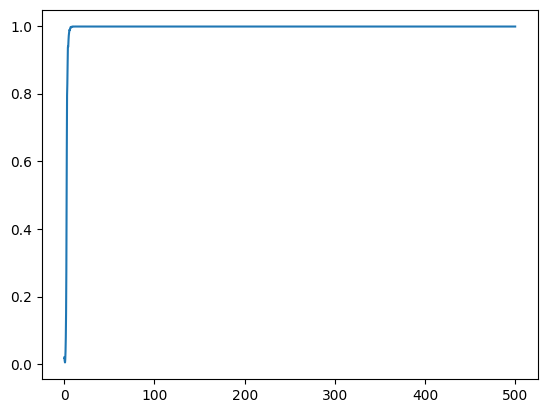

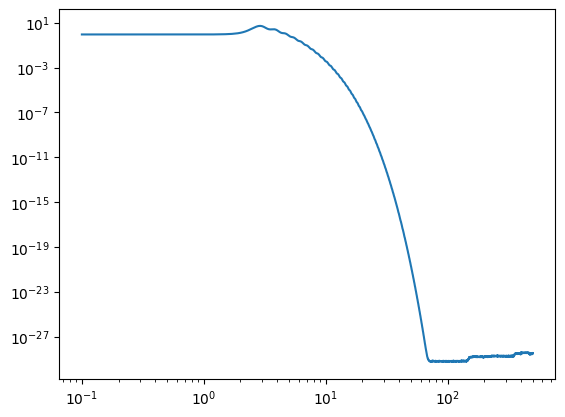

In [49]:
plt.plot(t,rs)

plt.figure()
plt.plot(t[1:],Vs[1:])
plt.xscale('log')
plt.yscale('log')

In [ ]:


%timeit sim(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta= omega,p_omega=omega)

In [43]:
%timeit np.array([*theta,*omega])

378 µs ± 3.61 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [44]:
%timeit np.r_[theta,omega]

7.2 µs ± 26.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [46]:
np.r_[theta,omega,0,1].shape

(10002,)

In [35]:
A = np.r_[theta,omega]

In [24]:
%timeit a,b = A[:N],A[N:2*N]

146 ns ± 0.933 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [36]:
theta,dtheta = A[:N],A[N:2*N]
r,psi = get_order_parameter(theta,N)
ddtheta = (-dtheta + omega + K*r*np.sin(psi - theta))
A = np.r_[dtheta,ddtheta,r,psi]

In [37]:
A[-2]

0.01999916553513436

In [38]:
%timeit r,psi = get_order_parameter(theta,N)

9.95 µs ± 143 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [39]:
%timeit V = np.var(dtheta)

4.97 µs ± 23.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [40]:
%timeit np.array([*theta,*dtheta])

38.9 µs ± 1.2 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [41]:
%timeit np.r_[theta,dtheta]


5.79 µs ± 24.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
Sol_Kuramoto_r()